In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import keras
import random

Using TensorFlow backend.


In [5]:
#getting the size of the convolution layer sizes

##convolution layer 1
filterSize1=5
numFilters1=16

##convolution layer 2
filterSize2= 5
numFilters2=36

##the final fully connected layer size
fullConnect=128

In [6]:
labelDict={0:"top",1:"Trouser",2:"Pullover",3:"Dress",4:"Coat",5:"Sandal",6:"Shirt",7:"Sneaker",8:"Bag",9:"Ankle boot"}


In [7]:
print("No of training examples: \t\t{}".format(len(trainImages)))
print("No of test eamples: \t\t\t{}".format(len(testImages)))

No of training examples: 		60000
No of test eamples: 			10000


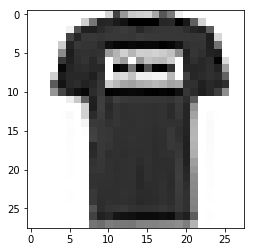

In [22]:
#parameters to pass through different layers
imgSize=trainImages[0].shape[0]
imgShape=trainImages[0].shape
plt.imshow(trainImages[1],cmap='binary')

In [17]:
def plotImages(trainImages,trainLabels):  
    for i in range(1,10):
        rand=random.randrange(0,60000)
        plt.subplot(3,3,i)
        plt.subplots_adjust(hspace=0.7,wspace=0.3)
        plt.imshow(trainImages[rand],cmap="binary")
        plt.xlabel(labelDict[trainLabels[rand]])

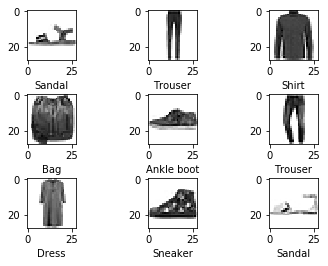

In [18]:
plotImages(trainImages,trainLabels)

In [24]:
#make a variable with some intial random values of the particular shape
def makeWeights(shape):
    return tf.Variable(tf.truncated_normal(shape,stddev=0.05))

In [27]:
a=tf.constant(0.05,shape=[5])


<tf.Tensor 'strided_slice:0' shape=() dtype=float32>

In [28]:
def newBiases(length):
    return tf.Variable(tf.constant(0.05,shape=[length]))

In [30]:
def makeConvLayer(inputLayer,
                  filterSize,
                  inputChannels,
                  numFilters,
                  maxPooling=True):
    
    #shape of a filter is determined in the following way
    ##shape=[no. of slides at a time of the filter,
    ##       dimensionality of the filter,
    ##        num of channels of filter,
    ##         number of filters]
    
    #in general a 4D tensor has the following format
    ##tensor=[Image number,
    ##            Y axis of each image,
    ##            X axis of the image,
    ##            Channels of each image]
    
    #NOTE: this is different from the way the shape of the filter is setup
    
    #strides is in the format of the tensor 
    ##strides=[Image Number=1 (because you stride over the same image)
    ##            steps in Y axis ,
    ##            steps in X axis,
    ##            Channels of each image=1]
    
    
    
    shape=[filterSize,filterSize,inputChannels,numFilters]
    
    #now make a filter with the random weights
    weights=makeWeights(shape=shape)
    
    #make biases which is a 1D vector
    biases=newBiases(length=numFilters)
    
    layer=tf.nn.conv2d(input=input,
                      filter=weights,
                      strides=[1,1,1,1],
                      padding='SAME')
    
    #addding the biases to the layers
    layer+=biases
    
    if(maxPooling):
        layer=tf.nn.max_pool(value=layer,
                            ksize=[1,2,2,1],
                            strides=[1,2,2,1],
                            padding='SAME')
        
    #adding the nonlinearity with ReLU
    layer=tf.nn.relu(layer)
    
    return layer

In [31]:
#the output of a conv layer is 4-D while a fully connected layer takes in only
#2-D tensor

def flattenLayer(layer):
    layerShape=layer.get_shape()
    #currently the layerShape is set to,
    ## layerShape=[numImages,imgXsize,imgYsize,no. of channels]
    ## this is to be reshaped in to the format 
    ## layerShape=[numImages,imgXsize*imgYsize*no.of channels]
    numFeatures=layerShape[1:4].num_elements()
    
    flatLayer=tf.reshape(layer,[-1,numFeatures])
    
    return flatLayer,numFeatures
    

In [ ]:
# the input is a 2D 

def fullConnected(input,
                 numInputs,    #previous layer shape
                 numOutputs,   #req. outptus
                 useRelu=True):
    #dont get confused here, if there are n inouts and m outputs
    #you need to have n*m weights and that is what this thing is doing
    weights=makeWeights(shape=[numInputs,numOutputs])
    biases=newBiases(length=numOutputs)
    
    layer=tf.matmul(input,weights)+biases
    
    if useRelu:
        layer=tf.nn.relu(layer)
    return layer 
    

In [32]:
#getting to work with the tensorflow placeholders and this will create inputs
#None is because of the fact that it can take any arbitrary values.
inputX=tf.placeholder(tf.float32,shape=[None,imgSize,imgSize,1])
outputTrue=tf.argmax(tf.placeholder(tf.float32,shape=[None,10]),axis=1)